In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os

 
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


<module 'matplotlib.pyplot' from '/home/sudu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

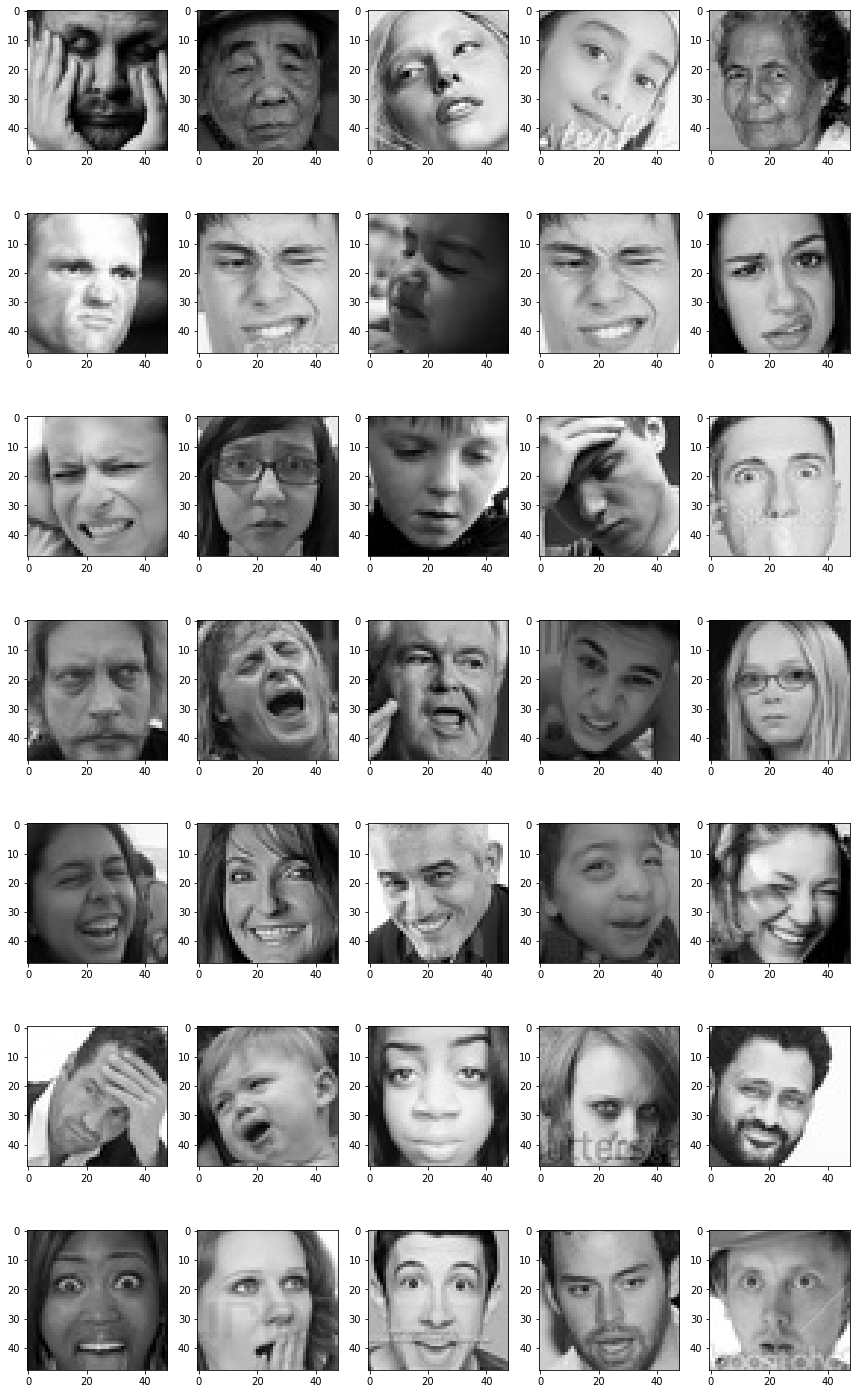

In [2]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("train/" + expression + "/" +os.listdir("train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt
plot_example_images(plt)

In [3]:
for expression in os.listdir('train/'):
    print(str(len(os.listdir('train/'+expression)))+" "+expression+" "+"images")

4965 neutral images
436 disgust images
4097 fear images
3995 angry images
7215 happy images
4830 sad images
3171 surprise images


In [4]:
for expression in os.listdir('test/'):
    print(str(len(os.listdir('test/'+expression)))+' '+expression+" " +"Image")

1233 neutral Image
111 disgust Image
1024 fear Image
958 angry Image
1774 happy Image
1247 sad Image
831 surprise Image


In [5]:
image_size=48
batch_size=64
train_gen=ImageDataGenerator(horizontal_flip=True)
traindata=train_gen.flow_from_directory('train',target_size=(image_size,image_size),color_mode='grayscale',class_mode='categorical',shuffle=True,batch_size=batch_size)

test_gen=ImageDataGenerator(horizontal_flip=True)
testdata=test_gen.flow_from_directory('test',target_size=(image_size,image_size),color_mode='grayscale',class_mode='categorical',shuffle=True,batch_size=batch_size)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [6]:
model=Sequential()
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7))
model.add(Activation('softmax'))




opt=Adam(lr=0.005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

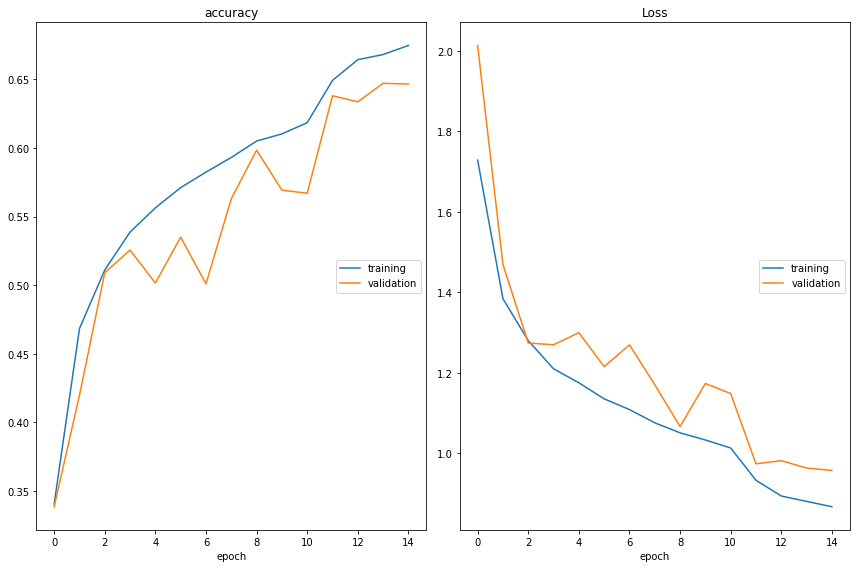

accuracy
	training         	 (min:    0.341, max:    0.675, cur:    0.675)
	validation       	 (min:    0.339, max:    0.647, cur:    0.646)
Loss
	training         	 (min:    0.867, max:    1.729, cur:    0.867)
	validation       	 (min:    0.957, max:    2.014, cur:    0.957)

Epoch 00015: saving model to model_weight.h5
448/448 [==============================] - 416s 928ms/step - loss: 0.8668 - accuracy: 0.6746 - val_loss: 0.9570 - val_accuracy: 0.6465


In [7]:
epochs=15
step_per_epoch=traindata.n//traindata.batch_size
validation_step=testdata.n//testdata.batch_size

checkpoint=ModelCheckpoint('model_weight.h5',monitor='val_accuracy',mode='max',save_weights_only=True,verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,mode='auto')

callbacks= [PlotLossesKeras(),checkpoint,reduce_lr]
history=model.fit(x=traindata,epochs=epochs,
                  steps_per_epoch=step_per_epoch,
                  validation_data=testdata,
                  validation_steps=validation_step,
                 callbacks=callbacks)


### Task 7: Represent Model as JSON String

In [ ]:
model_json=model.to_json()
with open('model.json', 'w') as jsonfile:
    jsonfile.write(model_json)